### HW3 part A by Denis Osipychev
##### import gym and local environments

In [1]:
import gym, myenv, time
import numpy as np
import matplotlib.pyplot as plt
import random
#dir(myenv)

In [2]:
# initialize the env and test it with a fixed action
env = gym.make("CartPole-v0") #env = myenv.AcrobotEnv()
print(env.reset())
for i in range(5):
    action = 1
    s,r,d,_ = env.step(action)
    #env.render()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[-0.01299069  0.02974108 -0.02666466  0.00461856]


In [12]:
# initialize hyperparameters
n_episodes = 10000
episode_lenght = 100
gamma = 0.99
alpha = 0.0001
epsilon = 1 # it will vary during the training
n_actions = 2
batch_size = 10

In [13]:
# import and initialize the TF q network
import tensorflow as tf
import tensorflow.contrib.slim as slim

class Qnetwork():
    def __init__(self):
        
        self.input = tf.placeholder(shape=[None,4],dtype=tf.float32)
        hidden = slim.fully_connected(self.input,10,biases_initializer=None,activation_fn=tf.nn.relu)
        self.output = slim.fully_connected(hidden,n_actions,activation_fn=tf.nn.softmax,biases_initializer=None)
        
        self.new_q = tf.placeholder(shape=[None,n_actions],dtype=tf.float32)
        
        self.loss = tf.reduce_sum(tf.square(self.new_q - self.output))
        optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
        self.update_model = optimizer.minimize(self.loss)

In [14]:
class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, arg):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [15]:
# epsilon greedy policy
def greedy_policy(Q):
    if np.random.uniform() < epsilon:
        best_action = np.random.randint(n_actions)
    else:
        best_action = np.argmax(Q)
    return best_action

In [16]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [17]:
# initialize the weights and network
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = Qnetwork()
merged = tf.summary.merge_all()

memory = ReplayMemory(1000)

In [18]:
# launch the session
sess = tf.Session()

# initialize, save or restore the network 
saver = tf.train.Saver(tf.global_variables())

writer = tf.summary.FileWriter('./logs', sess.graph)

ckpt = tf.train.get_checkpoint_state('./model')
if False: #ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [19]:
history = []
i = 0

# run the training
while i < n_episodes:
    
    s = env.reset()
    total_reward = 0
    i += 1
    j = 0
    d = False
    experience = []
    
    #run the simulation
    while j < episode_lenght:
        
        j += 1
        
        q = sess.run(myAgent.output,feed_dict={myAgent.input:np.reshape(s,[1,4])})
        action = greedy_policy(q)
        
        # do the step
        s_new,r,d,_ = env.step(action)
        
        q_next = sess.run(myAgent.output,feed_dict={myAgent.input:[s_new]})
        targetq = q.flatten()
        targetq[action] = r + gamma * np.max(q_next)
        
        memory.push([s,targetq])
        
        total_reward += r
        s = s_new
        
        if d == True:
            break
    
    # update q
    #if d == True:
    st, qt = zip(*memory.sample(batch_size))
    _, l = sess.run([myAgent.update_model,myAgent.loss],feed_dict={myAgent.input:st,
                                                 myAgent.new_q:qt})
   # print(l)
    # decay exploration
    epsilon = epsilon * 0.99995
    
    history.append([i, total_reward, epsilon, alpha])
    
    if i % 10 == 0:
        # save the model
        print(' Average r :', np.mean(np.asarray(history)[-10:,1]))
        saver.save(sess, './model/ctf_policy.ckpt')

 Average r : 21.6
 Average r : 22.6
 Average r : 24.8
 Average r : 16.8
 Average r : 15.9
 Average r : 25.9
 Average r : 19.7
 Average r : 28.8
 Average r : 23.1
 Average r : 21.5
 Average r : 23.6
 Average r : 27.8
 Average r : 18.2
 Average r : 15.3
 Average r : 19.2
 Average r : 20.5
 Average r : 17.2
 Average r : 23.6
 Average r : 22.5
 Average r : 29.6
 Average r : 19.2
 Average r : 25.3
 Average r : 21.4
 Average r : 20.6
 Average r : 22.4
 Average r : 21.9
 Average r : 30.7
 Average r : 23.2
 Average r : 25.6
 Average r : 23.9
 Average r : 19.5
 Average r : 20.5
 Average r : 20.0
 Average r : 25.5
 Average r : 20.7
 Average r : 25.3
 Average r : 21.0
 Average r : 25.1
 Average r : 20.1
 Average r : 28.5
 Average r : 21.1
 Average r : 16.6
 Average r : 16.0
 Average r : 21.4
 Average r : 18.9
 Average r : 20.7
 Average r : 16.2
 Average r : 24.5
 Average r : 19.7
 Average r : 19.0
 Average r : 21.5
 Average r : 21.1
 Average r : 21.6
 Average r : 19.0
 Average r : 24.2
 Average r

 Average r : 13.7
 Average r : 12.5
 Average r : 16.8
 Average r : 16.7
 Average r : 13.3
 Average r : 14.0
 Average r : 15.8
 Average r : 15.2
 Average r : 14.6
 Average r : 17.0
 Average r : 15.4
 Average r : 15.1
 Average r : 18.6
 Average r : 15.6
 Average r : 14.3
 Average r : 13.7
 Average r : 14.4
 Average r : 14.4
 Average r : 16.1
 Average r : 16.2
 Average r : 16.3
 Average r : 12.8
 Average r : 15.0
 Average r : 15.3
 Average r : 17.4
 Average r : 16.1
 Average r : 20.2
 Average r : 14.8
 Average r : 16.6
 Average r : 17.7
 Average r : 16.1
 Average r : 12.4
 Average r : 22.2
 Average r : 18.5
 Average r : 17.0
 Average r : 15.2
 Average r : 14.7
 Average r : 13.0
 Average r : 18.6
 Average r : 16.8
 Average r : 13.8
 Average r : 14.8
 Average r : 18.9
 Average r : 18.4
 Average r : 15.4
 Average r : 18.1
 Average r : 15.8
 Average r : 14.6
 Average r : 15.8
 Average r : 20.3
 Average r : 14.9
 Average r : 12.9
 Average r : 15.0
 Average r : 14.3
 Average r : 14.1
 Average r

 Average r : 13.6
 Average r : 12.0
 Average r : 11.6
 Average r : 13.5
 Average r : 14.1
 Average r : 13.7
 Average r : 14.4
 Average r : 11.9
 Average r : 13.2
 Average r : 16.3
 Average r : 13.4
 Average r : 15.0
 Average r : 14.5
 Average r : 12.4
 Average r : 15.5
 Average r : 13.7
 Average r : 13.2
 Average r : 13.9
 Average r : 12.3
 Average r : 13.3
 Average r : 14.8
 Average r : 11.6
 Average r : 12.3
 Average r : 15.4
 Average r : 13.8
 Average r : 14.9
 Average r : 12.9
 Average r : 13.6
 Average r : 14.4
 Average r : 11.9
 Average r : 12.4
 Average r : 14.1
 Average r : 13.2
 Average r : 13.8
 Average r : 13.6
 Average r : 13.6
 Average r : 13.1
 Average r : 13.0
 Average r : 13.8
 Average r : 15.1
 Average r : 14.8
 Average r : 13.6
 Average r : 10.7
 Average r : 11.1
 Average r : 15.1
 Average r : 14.1
 Average r : 15.2
 Average r : 14.2
 Average r : 12.8
 Average r : 13.3
 Average r : 13.3
 Average r : 16.0
 Average r : 14.0
 Average r : 13.5
 Average r : 11.9
 Average r

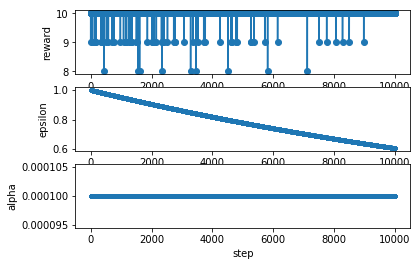

In [11]:
# plot the history
h = np.asarray(history)
plt.subplot(3, 1, 1)
plt.plot(h[:,0], h[:,1], 'o-')
plt.ylabel('reward')

plt.subplot(3, 1, 2)
plt.plot(h[:,0], h[:,2], '.-')
plt.xlabel('step')
plt.ylabel('epsilon')

plt.subplot(3, 1, 3)
plt.plot(h[:,0], h[:,3], '.-')
plt.xlabel('step')
plt.ylabel('alpha')

plt.show()

In [16]:
ckpt = tf.train.get_checkpoint_state('./model')

if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    print("No policy for evaluation")

# evaluate the policy
s = env.reset()
total_reward = 0
j = 0

while j < episode_lenght:
    j += 1
    q = sess.run(myAgent.output,feed_dict={myAgent.input:np.reshape(s,[1,4])})
    action = np.argmax(q)
    s_new,r,d,_ = env.step(action)
    total_reward += r
    s = s_new
    env.render()
    print(r)
print("total reward:", total_reward)

INFO:tensorflow:Restoring parameters from ./model/ctf_policy.ckpt
Load Model :  ./model/ctf_policy.ckpt


NotImplementedError: abstract

## Results:

The agent learned to do the swing motion, but the it cannot gain enough momentum.
There might be two reasons: 
<li>not enought force, so it cannot gain the momentum to flip the pendulum.
<li>not enough training, so the agent does not know the exact state when to change the force direction.